# Add a Training Loop

In [0]:
import numpy as np 
from sklearn import metrics

def activation(z, act_func):
    if act_func == 'relu':
       return np.maximum(z, np.zeros(z.shape))
    
    elif act_func == 'sigmoid':
      return 1.0/(1.0 + np.exp( -z ))

    elif act_func == 'linear':
        return z
    else:
        raise Exception('Activation function is not defined.')

def get_dactivation(A, act_func):
    if act_func == 'relu':
        return np.maximum(np.sign(A), np.zeros(A.shape)) 

    elif act_func == 'sigmoid':
        h = activation(A, 'sigmoid')
        return h *(1-h)

    elif act_func == 'linear':
        return np.ones(A.shape)

    else:
        raise Exception('Activation function is not defined.')

def loss(y_true, y_predicted, loss_function='mse'):
   if loss_function == 'mse':
      return metrics.mean_squared_error( y_true, y_predicted)
   else:
      raise Exception('Loss metric is not defined.')

def get_dZ_from_loss(y, y_predicted, metric):
    if metric == 'mse':
        return y_predicted - y
    else:
        raise Exception('Loss metric is not defined.')
           
class layer:
  def __init__(self,input_dim, output_dim, activation='relu'):    
    self.activation = activation
    self.input_dim = input_dim
    self.output_dim = output_dim # is this needed?? TODO
    if input_dim > 0:
      self.b = np.ones( (output_dim,1) )       
      self.W = np.ones( (output_dim, input_dim) )
      #self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2/input_dim) 
    
    self.A = np.zeros( (output_dim,1) ) # added: we temp. store for A
  
  def setWeight(self, W ):
    self.W = W
    
  def setBias(self, b ):
    self.b = b
    
  def setActivation(self, A ): 
    self.Z =  np.add( np.dot(self.W, A), self.b)
    self.A =  activation(self.Z, self.activation)
  
  
  def print(self, layer_name=""):
    print(f"Layer {layer_name}: Begin of Summary")
    if self.input_dim > 0:
      print(f"Layer {layer_name}: input_dim = {self.input_dim}")
      print(f"Layer {layer_name}: output_dim = {self.output_dim}")
      print(f"Layer {layer_name}: Activation = {self.activation}")
      print(f"W = ")
      print(self.W)
      print(f"A = ")
      print(self.A)
      print(f"b = ")
      print(self.b)
    else:
      print(f"Layer {layer_name}: This is an input layer..... ")
      print(f"A = ")
      print(self.A)
      
            
    
    print(f"Layer {layer_name}: End of Summary")
  

class ModelNet:
  def __init__(self, input_dim):  
    
    self.neural_net = []
    self.neural_net.append(layer(0 , input_dim, 'irrelevant'))
    
  def addLayer(self, nr_neurons, activation='relu'):    
    layer_index = len(self.neural_net)
    input_dim = self.neural_net[layer_index - 1].output_dim
    new_layer = layer( input_dim, nr_neurons, activation)
    self.neural_net.append( new_layer )
    
  
  def forward_propagation(self, input_vec ):
    self.neural_net[0].A = input_vec
    for layer_index in range(1,len(self.neural_net)):    
      _A_Prev = self.neural_net[layer_index-1].A                       
      self.neural_net[layer_index].setActivation( _A_Prev )
      
    return  self.neural_net[layer_index].A
    
  #added  
  def fit(self, input_vec, y_true, max_epoch, learning_rate=0.05, verbose=1 ):
    print(f"Start training for input_vec:")
    print( input_vec)
    print(f"Feature set entries: {input_vec.shape[1]}")
    
    num_train_datum = input_vec.shape[1]
    for epoch in range(0,max_epoch):    
      if (verbose > 0):
         print(f"Epoch {epoch}:")

      # Generate y_predicted
      y_predicted = self.forward_propagation( input_vec )


      # Do Backpropagation
      self.backward_propagation( y_true, y_predicted,  num_train_datum, verbose = verbose - 1 )

      # Update the weights an biases
      self.update( learning_rate )

      if (verbose > 0):
        print(f"Epoch {epoch}: Y-True = {y_true}")
        print(f"Epoch {epoch}: Y-Pred = {y_predicted}")
        print(f"Epoch {epoch}: Loss = {loss(y_true, y_predicted)}") 
        print(f"Epoch {epoch}: Finished")

    print(f"Epoch {epoch}: Y-True = {y_true}")
    print(f"Epoch {epoch}: Y-Pred = {y_predicted}")
    print(f"Epoch {epoch}: Loss = {loss(y_true, y_predicted)}")    
    print(f"Epoch {epoch}: Finished")
      
      
  def backward_propagation(self, y, y_predicted, num_train_datum, metric='mse', verbose=0):
    nr_layers = len(self.neural_net)
    for layer_index in range(nr_layers-1,0,-1):
        if layer_index+1 == nr_layers: # if output layer
            dZ = get_dZ_from_loss(y, y_predicted, metric)
        else: 
            dZ = np.multiply(
                   np.dot(
                       self.neural_net[layer_index+1].W.T, 
                       dZ), 
                   get_dactivation(
                         self.neural_net[layer_index].A, 
                         self.neural_net[layer_index].activation)
                   )
           
        
        dW = np.dot(dZ, self.neural_net[layer_index-1].A.T) / num_train_datum
        db = np.sum(dZ, axis=1, keepdims=True) / num_train_datum
        
        self.neural_net[layer_index].dW = dW
        self.neural_net[layer_index].db = db
        if (verbose > 0):
          print(f"\n\n====== Backward Propagation Layer {layer_index} =======")
          print(f"dZ      =  {dZ}")          
          print(f"dW      =  {dW}")
          print(f"A-1     = {self.neural_net[layer_index-1].A}") 
          print(f"\nb     =  {db}")
             

  def update( self, learning_rate ):
    nr_layers = len(self.neural_net)
    for layer_index in range(1,nr_layers):        # update (W,b)
      self.neural_net[layer_index].W = self.neural_net[layer_index].W - learning_rate * self.neural_net[layer_index].dW  
      self.neural_net[layer_index].b = self.neural_net[layer_index].b - learning_rate * self.neural_net[layer_index].db

  def summary(self):
      print("MODEL SUMMARY")
      for layer_index in range(len(self.neural_net)):        
        self.neural_net[layer_index].print(layer_index)
        
      print("FINISHED MODEL SUMMARY")
            


(1, 1)
Start training for input_vec:
[[1]
 [1]]
Feature set entries: 1
Epoch 0:
Epoch 0: Y-True = [[22]]
Epoch 0: Y-Pred = [[7.]]
Epoch 0: Loss = 225.0
Epoch 0: Finished
Epoch 1:
Epoch 1: Y-True = [[22]]
Epoch 1: Y-Pred = [[35.875]]
Epoch 1: Loss = 192.515625
Epoch 1: Finished
Epoch 2:
Epoch 2: Y-True = [[22]]
Epoch 2: Y-Pred = [[2.24384277]]
Epoch 2: Loss = 390.30574836065773
Epoch 2: Finished
Epoch 3:
Epoch 3: Y-True = [[22]]
Epoch 3: Y-Pred = [[12.14856963]]
Epoch 3: Loss = 97.05068034937943
Epoch 3: Finished
Epoch 4:
Epoch 4: Y-True = [[22]]
Epoch 4: Y-Pred = [[37.58449471]]
Epoch 4: Loss = 242.8764752813923
Epoch 4: Finished
Epoch 5:
Epoch 5: Y-True = [[22]]
Epoch 5: Y-Pred = [[6.03051775]]
Epoch 5: Loss = 255.0243633505901
Epoch 5: Finished
Epoch 6:
Epoch 6: Y-True = [[22]]
Epoch 6: Y-Pred = [[26.88846909]]
Epoch 6: Loss = 23.897130058036616
Epoch 6: Finished
Epoch 7:
Epoch 7: Y-True = [[22]]
Epoch 7: Y-Pred = [[10.39954098]]
Epoch 7: Loss = 134.57064951544467
Epoch 7: Finished
E

# Test

In [0]:
#Testing---------------------------------        
input_dim = 2
output_dim = 1
model = ModelNet( input_dim )
model.addLayer( 2, 'linear' )
model.addLayer( output_dim, 'linear' )

# Play with different feature set lengths..
# N=1
X  = np.array([[1], [1]])
y_true =np.array( [[22]] )

# N=2
#X  = np.array( [[0.,1.], [0.,1.]] ) 
#y_true = np.array( [[0., 7.]] )


# N=3
#X  = np.array( [[0.,1., 2.0], [0.,1., 2.0]] ) 
#y_true = np.array( [[-10., -11., -15.0]] )

print( y_true.shape )
model.fit( X, y_true, 3000, verbose=1)


# Check with Keras (optional)

X Shape : (3, 2)
Y_true Shape : (3, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
[array([[-0.6689986],
       [ 1.2921003]], dtype=float32), array([0.], dtype=float32)]


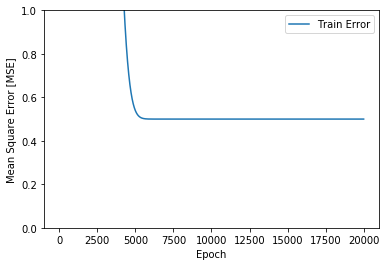

[[ -9.5]
 [-12. ]
 [-14.5]]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [MSE]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')

  plt.ylim([0,1])
  plt.legend()
  plt.show()


X  = np.array( [[0.,1., 2.0], [0.,1., 2.0]] ).T 
y_true = np.array( [[-10., -11., -15.0]] ).T
print(f"X Shape : { X.shape}" )
print(f"Y_true Shape : { y_true.shape}" )


model = Sequential()
model.add(Dense(2, input_dim=2, activation='relu')) # Hidden 1
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

w0 = []
w0.append(np.array([[1,1],[1,1]]))  # Weight Vectors in rows
w0.append(np.array( [1,1] ))        # Bias
#model.layers[0].set_weights( w0 )

w1 = []
w1.append(np.array([[1],[1]]))
w1.append(np.array( [1] ))  
#model.layers[1].set_weights( w1 )

print( model.layers[1].get_weights() )


history = model.fit(X,y_true,verbose=0,epochs=20000)

plot_history( history )

y = model.predict( X )
print( y )

